

```
# This is formatted as code
```

Function to get by MCMC Hernquist profile paramaters using 
NFW parameters from observations



In [1]:
#Bibliotecas 

import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.integrate import quad # will need for integration ('quadrature')
import numpy as np
import matplotlib.pyplot as plt
!pip install emcee
import emcee
!pip install corner
import corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Profiles 

def M_hernquist(M, a, r):
	'''
	Cumlative mass of Hernquist profile 
	'''
	return M * (r**2./(r+a)**2.)

def dehnen(r, M, a):
	#Dehnen profile, gamma = 1 is a Hernquist
  global gamma
  return ((3.-gamma)*M)/(4.*np.pi) * a/(r**gamma * (r+a)**(4.-gamma))

def nfw(r, rs, rho_s):
	#NFW profile
	return (rho_s)/((r/rs) * (1.+r/rs)**2.)
 
def beta(r, rho, rc, B):
  #beta profile
  return rho / (1+(r/rc)**2)**(3.*B/2)

In [11]:
# Analysis 
def model(theta,r):
	#fitting model
	M_dm, a = theta
	return dehnen(r, M_dm, a)
	
def lnlike(theta, x, y, yerr):
	#Likehood
	return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

def lnprior(theta):
	#prior
	M_dm, a = theta
	if 0.1 < M_dm < 100 and 50 < a < 2000:
		return 0.0
	return -np.inf

def lnprob(theta, x, y, yerr):
	#prob
	lp = lnprior(theta)
	if not np.isfinite(lp):
		return -np.inf
	return lp + lnlike(theta, x, y, yerr)

In [12]:
def main(p0,nwalkers,niter,ndim,lnprob,data):

  sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
  print("Running burn-in...")
  p0, _, _ = sampler.run_mcmc(p0, 2500)
  sampler.reset()

  print("Running production...")
  pos, prob, state = sampler.run_mcmc(p0, niter)
  return sampler, pos, prob, state
    
def plotter(sampler,r,des):
  plt.ion()
  plt.loglog(r,des* 6.77e-22,label='Density profile')
  samples = sampler.flatchain
  for theta in samples[np.random.randint(len(samples), size=100)]:
    plt.loglog(r, model(theta, r)* 6.77e-22, color="r", alpha=0.1)
	  #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
  plt.xlabel('$R\ \ [kpc]$')
  plt.ylabel('$\\rho\ \ [g/cm^3]$')
  plt.legend(frameon=False)
  plt.savefig('nfw_profile.png', bbox_inches='tight')

In [13]:
#DM
#VALORES PARA ALTERAR
def function(rs, c200, log10M200, r200):
  global gamma
  gamma = 1
  M200 = 10.**(log10M200)/1e14 # 1e14 Msun
  pc_200 = 2.798e-6*1e-4 #200*rho_{crit} 1e14 Msun/ kpc^3

  #gas fraction Dvorkin&Rephaeli 2015
  a_par = np.mean([14.29, 13.87, 14.45, 14.32, 13.95])
  b = np.mean([0.135, 0.189, 0.251, 0.148, 0.295])
  c = np.mean([0.051, 0.028, 0.053, 0.029, 0.071])
  d = np.mean([0.072, 0.099, 0.081, 0.059, 0.078])


  exp = 1. + np.exp((-log10M200 + a_par)/b)
  fgas = (c/exp)+ d

  #NFW parameter
  rho_s = (pc_200/3.)*c200**3./(np.log(1.+c200)-c200/(1.+c200))

  #X and y definition
  r = np.logspace(np.log10(1e-3), np.log10(5.*r200), 500)

  rho_nfw = nfw(r, rs, rho_s)
  rho_nfw_max = nfw(r, 1.01*rs, 1.01*rho_s)
  rho_nfw_min = nfw(r, 0.99*rs, 0.99*rho_s)
  #Start 
  sigma_nfw = np.std([rho_nfw, rho_nfw_max, rho_nfw_min], axis=0) #error definition
  data = (r, rho_nfw,sigma_nfw)
  nwalkers = 500
  niter = 20000
  initial = np.array([M200, rs])

  ndim = len(initial)
  p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
  sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

  samples = sampler.flatchain
  theta_max  = samples[np.argmax(sampler.flatlnprobability)]

  M = theta_max[0]
  a = theta_max[1]
  print("Mass = %4.2f 1e14 Msun" %M)
  print("fgas = %4.2f" %fgas)
  print("a = %4.2f kpc" %a)

  plots(sampler, rs, c200, log10M200, r200)
  
  return M, a, fgas

In [9]:
def plots(sampler, rs, c200, log10M200, r200):
  #Highest Likelihood Model
  global gamma
  gamma = 1
  M200 = 10.**(log10M200)/1e14 # 1e14 Msun
  pc_200 = 2.798e-6*1e-4 #200*rho_{crit} 1e14 Msun/ kpc^3

  #NFW parameter
  rho_s = (pc_200/3.)*c200**3./(np.log(1.+c200)-c200/(1.+c200))

  #X and y definition
  r = np.logspace(np.log10(1e-3), np.log10(5.*r200), 500)

  rho_nfw = nfw(r, rs, rho_s)

  plotter(sampler, r, rho_nfw)
  samples = sampler.flatchain

  theta_max  = samples[np.argmax(sampler.flatlnprobability)]
  best_fit_model = model(theta_max, r)
  plt.loglog(r,rho_nfw* 6.77e-22,label='NFW profile')
  plt.loglog(r,best_fit_model* 6.77e-22,label='Highest Likelihood Hernquist profile')
  plt.xlabel('$R\ \ [kpc]$')
  plt.ylabel('$\\rho\ \ [g/cm^3]$')
  plt.legend(frameon=False)
  plt.show()

  M = theta_max[0]
  a = theta_max[1]
  
  labels = ['M$_{dm}$ [1e14 Msun]','a [kpc]']
  fig = corner.corner(samples,show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.50, 0.84],  truths=list([M,a]))
  plt.show()

Running burn-in...
Running production...
Mass = 4.00 1e14 Msun
fgas = 0.12
a = 263.39 kpc


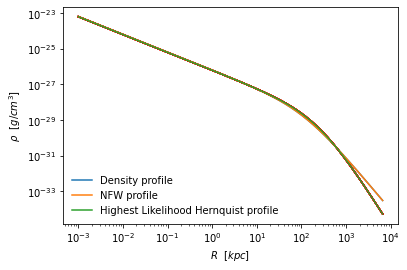

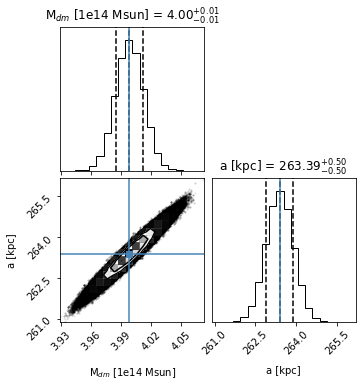

Running burn-in...
Running production...
Mass = 6.24 1e14 Msun
fgas = 0.12
a = 426.76 kpc


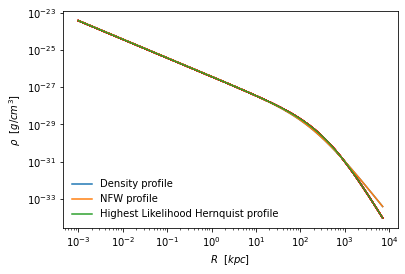

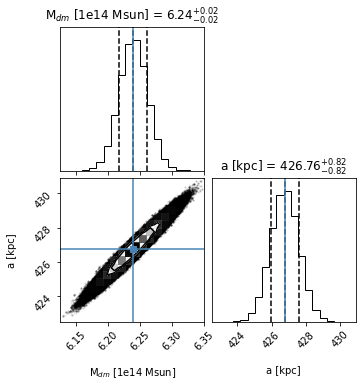

Running burn-in...
Running production...
Mass = 11.14 1e14 Msun
fgas = 0.12
a = 559.44 kpc


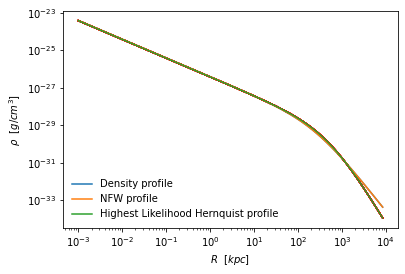

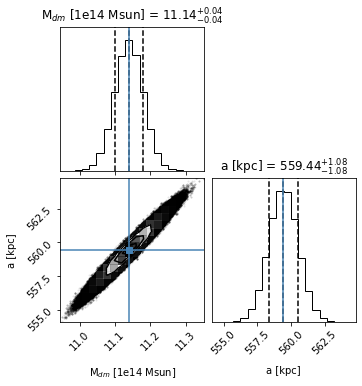

Running burn-in...
Running production...
Mass = 13.74 1e14 Msun
fgas = 0.12
a = 675.40 kpc


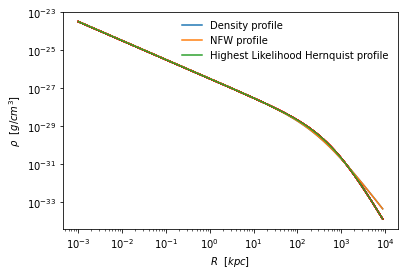

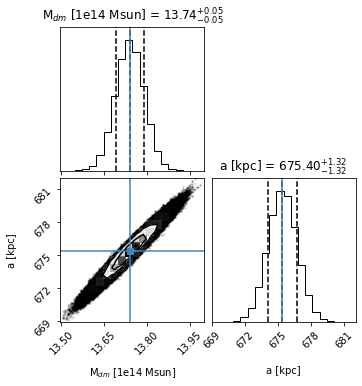

Running burn-in...
Running production...
Mass = 23.99 1e14 Msun
fgas = 0.12
a = 930.22 kpc


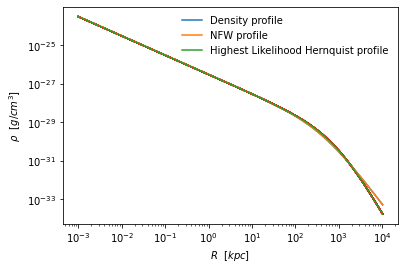

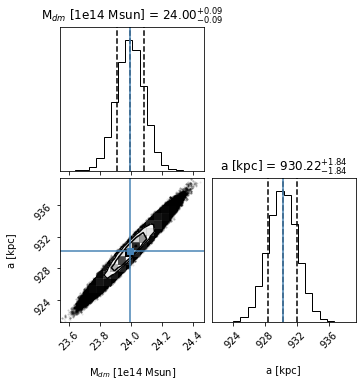

Running burn-in...
Running production...
Mass = 38.27 1e14 Msun
fgas = 0.12
a = 1475.93 kpc


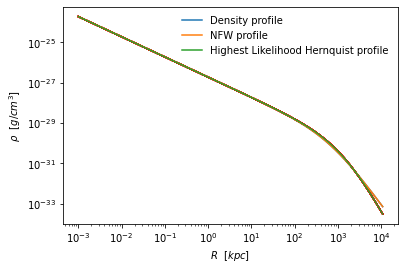

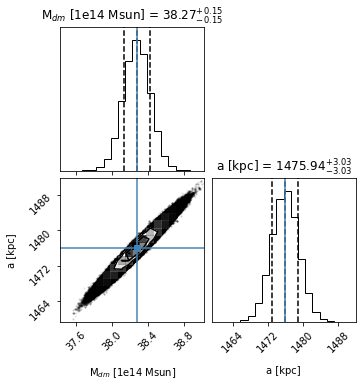

Running burn-in...
Running production...
Mass = 53.56 1e14 Msun
fgas = 0.12
a = 1563.09 kpc


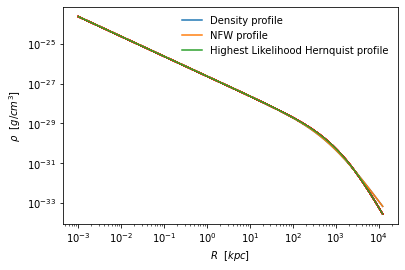

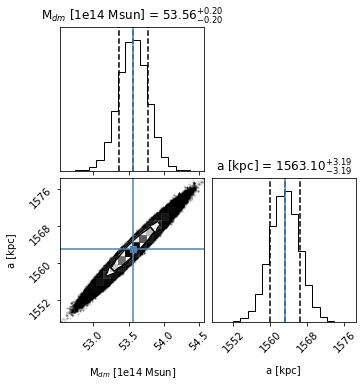

In [14]:
rs_vec = np.array([119., 197., 260., 317., 442., 725., 763.])
cs_vec = np.array([11.03, 7.21, 6.51, 5.56, 4.63, 2.99, 3.24]) 
log10M_vec = np.array([14.56, 14.61, 14.82, 14.92, 15.12, 15.16, 15.34])
r200_vec = np.array([1318., 1430., 1691., 1760., 2050., 2164., 2470.]) 

M = np.zeros(len(rs_vec))
a = np.zeros(len(rs_vec))
fgas = np.zeros(len(rs_vec))
for i in range(len(rs_vec)):
  M[i], a[i], fgas[i] = function(rs_vec[i], cs_vec[i], log10M_vec[i], r200_vec[i])

In [17]:
Mvar, a_var, fgas_var = M, a, fgas

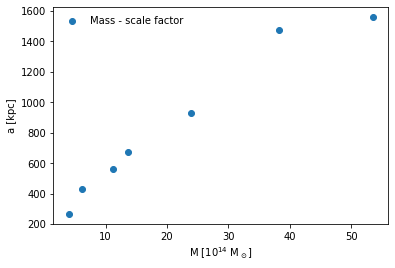

In [18]:
plt.scatter(Mvar,a_var,label='Mass - scale factor')
plt.xlabel('M [$10^{14}$ M$_\odot$]')
plt.ylabel('a [kpc]')
plt.legend(frameon=False)
plt.show()

In [21]:
 import scipy 

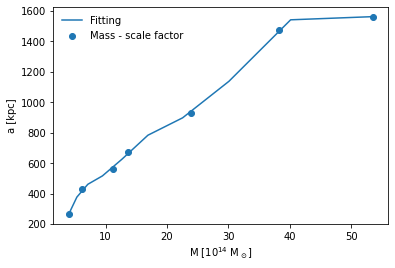

3.998e+14  14.60 263.39
5.335e+14  14.73 376.53
7.118e+14  14.85 460.70
9.496e+14  14.98 515.91
1.267e+15  15.10 625.43
1.690e+15  15.23 783.40
2.255e+15  15.35 897.70
3.009e+15  15.48 1137.65
4.015e+15  15.60 1542.18
5.356e+15  15.73 1563.09


In [42]:
xs = np.logspace(np.log10(min(Mvar)), np.log10(max(Mvar)), 10)
fit = scipy.interpolate.make_interp_spline(Mvar, a_var)	
ys = fit(xs)

plt.scatter(Mvar,a_var,label='Mass - scale factor')
plt.plot(xs, ys, label='Fitting')
plt.xlabel('M [$10^{14}$ M$_\odot$]')
plt.ylabel('a [kpc]')
plt.legend(frameon=False)
plt.show()

for i in range(len(xs)):
  print("%4.3e  %4.2f %4.2f" %(xs[i]*1e14, np.log10(xs[i]*1e14), ys[i]))

In [37]:
xvar = np.linspace(min(Mvar), max(Mvar), 10)
yvar = fit(xvar)
xvar, yvar

for i in range(len(xvar)):
  print("%4.2e  %4.2f %4.2f" %(xvar[i]*1e14, np.log10(xvar[i]*1e14),  yvar[i]))

4.00e+14  14.60 263.39
9.51e+14  14.98 516.11
1.50e+15  15.18 726.04
2.05e+15  15.31 858.89
2.60e+15  15.42 988.20
3.15e+15  15.50 1197.41
3.70e+15  15.57 1428.35
4.25e+15  15.63 1612.16
4.81e+15  15.68 1680.02
5.36e+15  15.73 1563.09


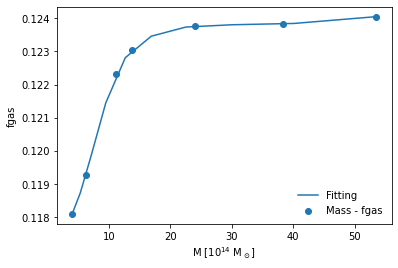

4.722e+13  13.67 0.12
6.334e+13  13.80 0.12
8.531e+13  13.93 0.12
1.153e+14  14.06 0.12
1.556e+14  14.19 0.12
2.087e+14  14.32 0.12
2.791e+14  14.45 0.12
3.725e+14  14.57 0.12
4.972e+14  14.70 0.12
6.644e+14  14.82 0.12


In [43]:
xs = np.logspace(np.log10(min(Mvar)), np.log10(max(Mvar)), 10)
fit2 = scipy.interpolate.make_interp_spline(Mvar, fgas)	
ys = fit2(xs)

plt.scatter(Mvar,fgas,label='Mass - fgas')
plt.plot(xs, ys, label='Fitting')
plt.xlabel('M [$10^{14}$ M$_\odot$]')
plt.ylabel('fgas')
plt.legend(frameon=False)
plt.show()

for i in range(len(xs)):
  print("%4.3e  %4.2f %4.2f" %(xs[i]*ys[i]*1e14, np.log10(xs[i]*ys[i]*1e14),  ys[i]))


In [36]:
min(xs),fit(3)

(3.998417067909238, array(139.98419107))